In [17]:
import numpy as np
from scipy.io import loadmat
from scipy import signal, stats, fft
import matplotlib.pyplot as plt 

Load in vivo data

In [18]:
datafile = '/home/matt/data/InVivoLFPs/BLA_LFP_data/Part2SubjectHB15_AW.mat'
data = loadmat(datafile)

fs = data['fs'][0,0]
scale = data['scale'][0,0]
LFP_seg = [scale*x.ravel() for x in data['LFP_seg'].ravel()]

LFP_cat = np.concatenate(LFP_seg)

Get PSD of in vivo LFP and fit 1/f^a

In [19]:
nfft = 2**8 #7 # 128 samples
print(LFP_cat.shape)

f, Pxx = signal.welch(LFP_cat, fs=fs, window='hamming', nperseg=nfft, scaling='spectrum')
f = f.ravel()

f_cutoff = max(np.argmax(Pxx),1)
Pmax = Pxx[f_cutoff]
idx = np.arange(f_cutoff,f.size)
result = stats.linregress(np.log(f[idx]),np.log(Pxx[idx]))
b = result.intercept
a = -result.slope

f_cutoff = np.exp((b-np.log(Pmax))/a)
idx = f>f_cutoff
Pfit = Pxx.copy()
Pfit[idx] = np.exp(b)/f[idx]**a
Pfit[~idx] = Pmax

(2899042,)


Normalization factors for fourier coefficients in the loss function

In [20]:
norm_factor = np.sqrt(Pmax/Pfit)
print(norm_factor)
# Using FFT with nfft
print(nfft)

[  1.           1.           1.3680824    2.08589212   2.81358362
   3.5487126    4.28982339   5.03594594   5.78638595   6.54062122
   7.29824433   8.05892832   8.82240486   9.58844968  10.3568725
  11.12750977  11.90021939  12.67487673  13.45137157  14.22960572
  15.00949114  15.79094845  16.57390569  17.35829731  18.14406337
  18.93114882  19.71950295  20.50907887  21.2998331   22.09172519
  22.88471745  23.67877465  24.47386378  25.26995387  26.06701577
  26.86502204  27.66394674  28.46376538  29.26445476  30.06599285
  30.86835877  31.67153263  32.47549551  33.28022937  34.08571698
  34.8919419   35.69888838  36.50654138  37.31488645  38.12390974
  38.93359797  39.74393836  40.55491864  41.36652698  42.17875202
  42.99158278  43.80500868  44.61901954  45.43360548  46.248757
  47.06446488  47.88072022  48.69751441  49.5148391   50.33268621
  51.15104789  51.96991655  52.78928482  53.60914553  54.42949173
  55.25031667  56.07161377  56.89337667  57.71559913  58.53827512
  59.36139876

Define function for generating pink noise

In [21]:
def pink_noise(f, alpha=1., fmin=0):
    """
    f: normalized frequencies
    alpha: exponent of pink noise
    fmin: Low-frequency cutoff
    """
    S = 1/np.where(f == 0, float('inf'), f**(alpha/2))
    if fmin>0:
        S[(f<fmin) & (f!=0)] = fmin**(-alpha/2)
    return S

def noise_gen(N, psd = lambda f: 1):
    f = fft.rfftfreq(N)
    Scale = psd(f)
    w = Scale[1:].copy()
    w[-1] *= (1 + (N % 2)) / 2. # correct f = +-0.5
    sigma = 2 * np.sqrt(np.sum(w**2)) / N
    sr = Scale * np.random.randn(len(f))
    si = Scale * np.random.randn(len(f))
    if not (N % 2): si[-1] = 0 # If the signal length is even, frequencies +/- 0.5 are equal, the coefficient must be real.
    si[0] = 0 # Regardless of signal length, the DC component must be real
    s  = sr + 1J * si
    X = fft.irfft(s) / sigma
    return X

Generate pink noise and get its PSD

In [22]:
N = 2**((LFP_cat.size-1).bit_length()-1) # choose power of 2 samples
noise_psd = lambda f: pink_noise(f, alpha=a, fmin=f_cutoff/fs) # function for calculating noise psd
x_noise = np.std(LFP_cat) * noise_gen(N, psd = noise_psd)

_, Pxx_noi = signal.welch(x_noise, fs=fs, window='hamming', nperseg=nfft, scaling='spectrum')

# Compare power in each signal
print(np.std(LFP_cat))
print(np.std(x_noise))

53.89281228765393
53.88624480396772


Plot PSD

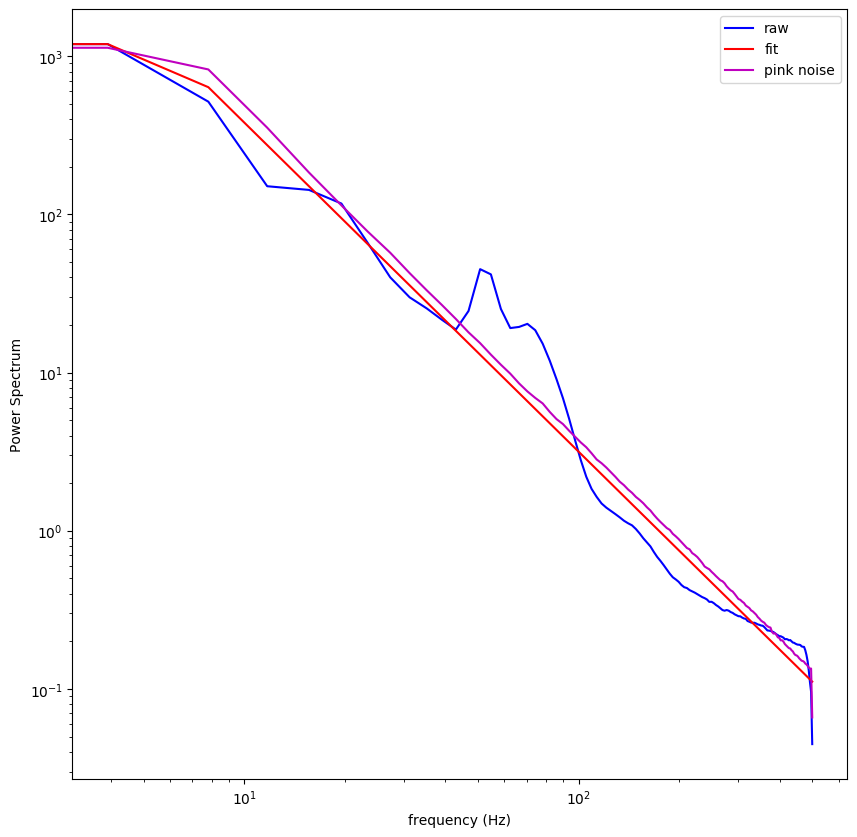

In [23]:
LinearScale = False

plt.figure(figsize=(10,10))
if LinearScale:
    plt.plot(f, Pxx, 'b', label='raw')
    plt.plot(f, Pfit, 'r', label='fit')
    plt.plot(f, Pxx_noi, 'm', label='pink noise')
else:
    plt.loglog(f, Pxx, 'b', label='raw')
    plt.loglog(f, Pfit, 'r', label='fit')
    plt.loglog(f, Pxx_noi, 'm', label='pink noise')
plt.xlabel("frequency (Hz)")
plt.ylabel("Power Spectrum")
plt.legend()
plt.show()

Plot example pink noise trace

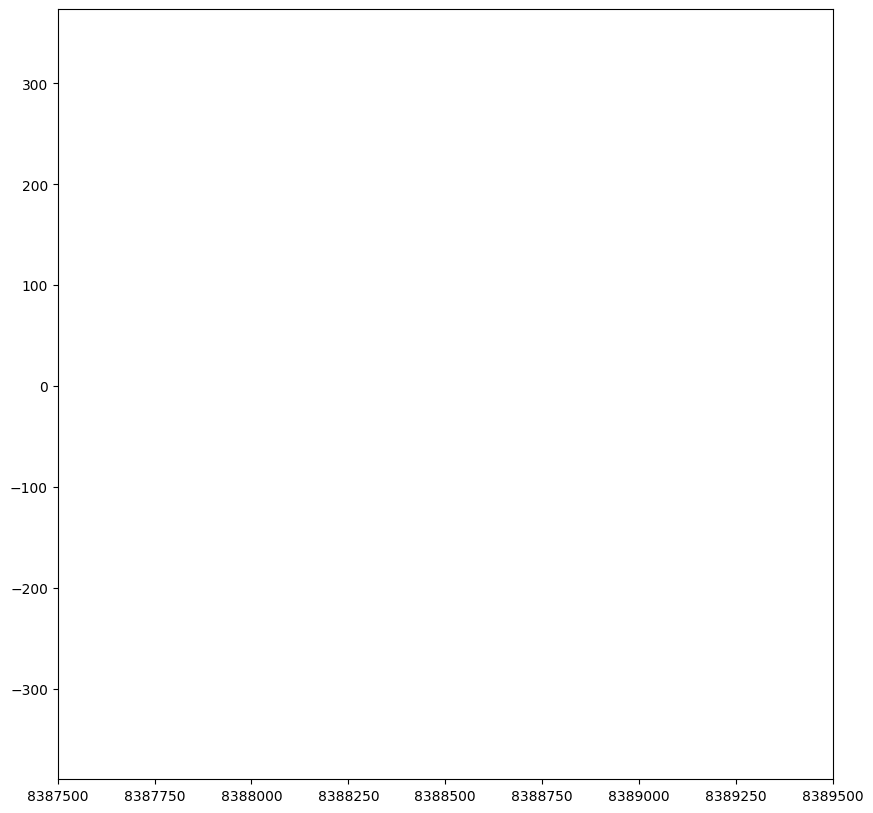

In [24]:
# %matplotlib inline

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(LFP_cat, 'b')
ax.plot(x_noise, 'r')
ax.set_xlim(left=8.3875e6, right=8.3895e6)
plt.show()